## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], BN='BEF'):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if BN=='BEF':
                x = BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            if BN=='AFT':
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
        else:
            if BN=='BEF':
                x = BatchNormalization()(x)
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            if BN=='AFT':
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [16, 64, 256]
MOMENTUM = 0.95
BN = ['BEF', 'AFT']

In [7]:
#使用迴圈建立不同的帶不同 drp_ratio 的模型並訓練
import itertools

results = {}
for BatchSize, BatchNormal in itertools.product(BATCH_SIZE, BN):
  
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:], BN=BatchNormal)
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BatchSize, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "bts(%s)/btl(%s)" % (str(BatchSize),str(BatchNormal))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               3289

50000/50000 [==============================] - 84s 2ms/step - loss: 0.5858 - accuracy: 0.7912 - val_loss: 1.5207 - val_accuracy: 0.5466
Epoch 47/50
50000/50000 [==============================] - 82s 2ms/step - loss: 0.5801 - accuracy: 0.7919 - val_loss: 1.5477 - val_accuracy: 0.5483
Epoch 48/50
50000/50000 [==============================] - 92s 2ms/step - loss: 0.5742 - accuracy: 0.7951 - val_loss: 1.5299 - val_accuracy: 0.5522
Epoch 49/50
50000/50000 [==============================] - 87s 2ms/step - loss: 0.5668 - accuracy: 0.7989 - val_loss: 1.5466 - val_accuracy: 0.5567
Epoch 50/50
50000/50000 [==============================] - 82s 2ms/step - loss: 0.5572 - accuracy: 0.8005 - val_loss: 1.5672 - val_accuracy: 0.5517
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________

50000/50000 [==============================] - 69s 1ms/step - loss: 1.1332 - accuracy: 0.5987 - val_loss: 1.3164 - val_accuracy: 0.5375
Epoch 42/50
50000/50000 [==============================] - 68s 1ms/step - loss: 1.1262 - accuracy: 0.6010 - val_loss: 1.3483 - val_accuracy: 0.5357
Epoch 43/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.1265 - accuracy: 0.6008 - val_loss: 1.3288 - val_accuracy: 0.5356
Epoch 44/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.1170 - accuracy: 0.6041 - val_loss: 1.3375 - val_accuracy: 0.5347
Epoch 45/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.1139 - accuracy: 0.6061 - val_loss: 1.3496 - val_accuracy: 0.5284
Epoch 46/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.1126 - accuracy: 0.6056 - val_loss: 1.3532 - val_accuracy: 0.5280
Epoch 47/50
50000/50000 [==============================] - 69s 1ms/step - loss: 1.1188 - accuracy: 0.6028 - val_loss: 1.3479

50000/50000 [==============================] - 27s 547us/step - loss: 0.1965 - accuracy: 0.9340 - val_loss: 2.2442 - val_accuracy: 0.5327
Epoch 37/50
50000/50000 [==============================] - 28s 555us/step - loss: 0.1957 - accuracy: 0.9329 - val_loss: 2.2666 - val_accuracy: 0.5249
Epoch 38/50
50000/50000 [==============================] - 27s 547us/step - loss: 0.1939 - accuracy: 0.9329 - val_loss: 2.2573 - val_accuracy: 0.5292
Epoch 39/50
50000/50000 [==============================] - 27s 546us/step - loss: 0.1803 - accuracy: 0.9386 - val_loss: 2.2869 - val_accuracy: 0.5328
Epoch 40/50
50000/50000 [==============================] - 27s 548us/step - loss: 0.1699 - accuracy: 0.9417 - val_loss: 2.3044 - val_accuracy: 0.5254
Epoch 41/50
50000/50000 [==============================] - 28s 552us/step - loss: 0.1709 - accuracy: 0.9418 - val_loss: 2.3116 - val_accuracy: 0.5292
Epoch 42/50
50000/50000 [==============================] - 27s 546us/step - loss: 0.1676 - accuracy: 0.9428 - va

Epoch 31/50
50000/50000 [==============================] - 23s 468us/step - loss: 0.7213 - accuracy: 0.7433 - val_loss: 1.6383 - val_accuracy: 0.4902
Epoch 32/50
50000/50000 [==============================] - 25s 504us/step - loss: 0.7060 - accuracy: 0.7483 - val_loss: 1.7481 - val_accuracy: 0.4777
Epoch 33/50
50000/50000 [==============================] - 24s 480us/step - loss: 0.7013 - accuracy: 0.7504 - val_loss: 1.8436 - val_accuracy: 0.4688
Epoch 34/50
50000/50000 [==============================] - 23s 464us/step - loss: 0.6853 - accuracy: 0.7570 - val_loss: 1.7516 - val_accuracy: 0.4779
Epoch 35/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.6726 - accuracy: 0.7583 - val_loss: 1.8418 - val_accuracy: 0.4718
Epoch 36/50
50000/50000 [==============================] - 23s 465us/step - loss: 0.6506 - accuracy: 0.7691 - val_loss: 1.9451 - val_accuracy: 0.4732
Epoch 37/50
50000/50000 [==============================] - 24s 477us/step - loss: 0.6481 - accuracy:

Epoch 26/50
50000/50000 [==============================] - 16s 316us/step - loss: 0.2630 - accuracy: 0.9305 - val_loss: 1.8341 - val_accuracy: 0.5094
Epoch 27/50
50000/50000 [==============================] - 16s 317us/step - loss: 0.2519 - accuracy: 0.9331 - val_loss: 1.8725 - val_accuracy: 0.5140
Epoch 28/50
50000/50000 [==============================] - 16s 315us/step - loss: 0.2249 - accuracy: 0.9410 - val_loss: 1.9229 - val_accuracy: 0.5075
Epoch 29/50
50000/50000 [==============================] - 16s 329us/step - loss: 0.2014 - accuracy: 0.9504 - val_loss: 1.9536 - val_accuracy: 0.5140
Epoch 30/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.1826 - accuracy: 0.9574 - val_loss: 2.0043 - val_accuracy: 0.5103
Epoch 31/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.1642 - accuracy: 0.9617 - val_loss: 2.0567 - val_accuracy: 0.5090
Epoch 32/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.1545 - accuracy:

Epoch 21/50
50000/50000 [==============================] - 11s 228us/step - loss: 0.7178 - accuracy: 0.7565 - val_loss: 1.6234 - val_accuracy: 0.4868
Epoch 22/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.6872 - accuracy: 0.7698 - val_loss: 1.6822 - val_accuracy: 0.4766
Epoch 23/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.6639 - accuracy: 0.7768 - val_loss: 1.6656 - val_accuracy: 0.4829
Epoch 24/50
50000/50000 [==============================] - 11s 224us/step - loss: 0.6358 - accuracy: 0.7874 - val_loss: 1.7061 - val_accuracy: 0.4746
Epoch 25/50
50000/50000 [==============================] - 11s 227us/step - loss: 0.6056 - accuracy: 0.7974 - val_loss: 1.7203 - val_accuracy: 0.4740
Epoch 26/50
50000/50000 [==============================] - 11s 225us/step - loss: 0.5826 - accuracy: 0.8063 - val_loss: 1.8840 - val_accuracy: 0.4632
Epoch 27/50
50000/50000 [==============================] - 11s 227us/step - loss: 0.5556 - accuracy:

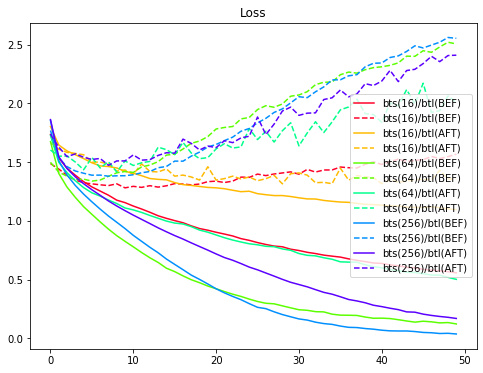

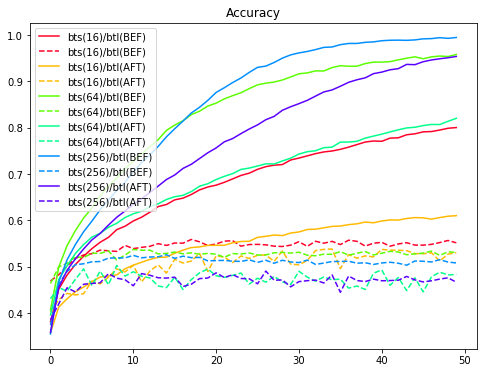

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()